# Install Library

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from sklearn.preprocessing import StandardScaler

# Memuat Dataset

In [ ]:
file_path = 'review.csv'
data = pd.read_csv(file_path)

# Missing Values

In [ ]:
# Cek nilai yang hilang
missing_values = data.isnull().sum()

# Menghapus kolom yang tidak perlu atau isi nilai yang hilang
# Di sini, kita menghapus 'review_comment_title' karena mungkin memiliki terlalu banyak nilai kosong
data_cleaned = data.drop(columns=['review_comment_title'])
print("Ringkasan Nilai yang Hilang:\n", missing_values)

Ringkasan Nilai yang Hilang:
 review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


# Fill Missing Values

In [ ]:
# Isi pesan yang hilang dengan string 'Unknown'
data['review_comment_message'] = data['review_comment_message'].fillna('Unknown')

# Menampilkan data yang sudah diisi pada kolom 'review_comment_message'
print("Setelah mengisi nilai kosong dengan 'Unknown':\n")
print(data[['review_comment_message']].head())

Setelah mengisi nilai kosong dengan 'Unknown':

                              review_comment_message
0                                            Unknown
1                                            Unknown
2                                            Unknown
3              Recebi bem antes do prazo estipulado.
4  Parabéns lojas lannister adorei comprar pela I...


# Cleaned Data

In [ ]:
# Ubah kolom tanggal ke format datetime
data_cleaned['review_creation_date'] = pd.to_datetime(data_cleaned['review_creation_date'])
data_cleaned['review_answer_timestamp'] = pd.to_datetime(data_cleaned['review_answer_timestamp'])

# Encode 'review_comment_message' (contoh: hitung jumlah kata)
# Tangani missing values atau tipe data yang bukan string
data_cleaned['message_word_count'] = data_cleaned['review_comment_message'].apply(
    lambda x: len(str(x).split()) if pd.notnull(x) else 0
)

print("\nData yang Telah Dibersihkan:\n", data_cleaned.head())

# Simpan data yang telah dibersihkan ke file CSV
data_cleaned.to_csv('cleaned_review.csv', index=False)


Data yang Telah Dibersihkan:
                           review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score                             review_comment_message  \
0             4                                                NaN   
1             5                                                NaN   
2             5                                                NaN   
3             5              Recebi bem antes do prazo estipulado.   
4             5  Parabéns lojas lannister adorei comprar pela I...   

  review_creation_date review_answer_timestamp  message_word_count  
0           2018-01-18     2018-01-18 21

# Standardisasi

In [ ]:
# Standarisasi isi kolom review_comment_message ke huruf besar (uppercase)
data['review_comment_message'] = data['review_comment_message'].str.upper()

print("Data setelah kolom 'review_comment_message' distandarisasi ke huruf besar:\n")
print(data[['review_comment_message']].head())

Data setelah kolom 'review_comment_message' distandarisasi ke huruf besar:

                              review_comment_message
0                                            UNKNOWN
1                                            UNKNOWN
2                                            UNKNOWN
3              RECEBI BEM ANTES DO PRAZO ESTIPULADO.
4  PARABÉNS LOJAS LANNISTER ADOREI COMPRAR PELA I...


# Normalisasi

In [ ]:
file_path = "cleaned_review.csv"
data = pd.read_csv(file_path)

# Pastikan kolom 'message_word_count' tidak memiliki nilai kosong
data['message_word_count'] = data['message_word_count'].fillna(0).astype(int)

# Normalisasi kolom 'message_word_count'
scaler = MinMaxScaler()
data['normalized_message_word_count'] = scaler.fit_transform(data[['message_word_count']])

# Langkah 4: Menampilkan hasil
print("Data setelah normalisasi:\n")
print(data[['message_word_count', 'normalized_message_word_count']].head())

Data setelah normalisasi:

   message_word_count  normalized_message_word_count
0                   0                       0.000000
1                   0                       0.000000
2                   0                       0.000000
3                   6                       0.133333
4                  15                       0.333333


# Basic Plotting with Matplotlib

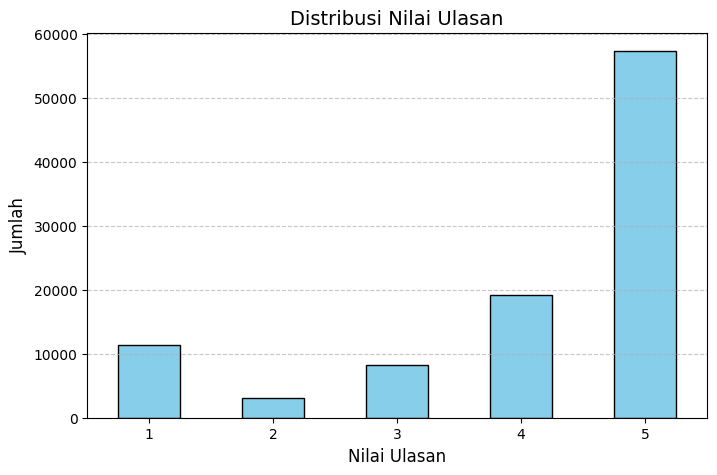

In [ ]:
# Membuat plot distribusi nilai ulasan
plt.figure(figsize=(8, 5))
data['review_score'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

# Menambahkan label dan judul
plt.title('Distribusi Nilai Ulasan', fontsize=14)
plt.xlabel('Nilai Ulasan', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Seaborn for Relationship Visualization

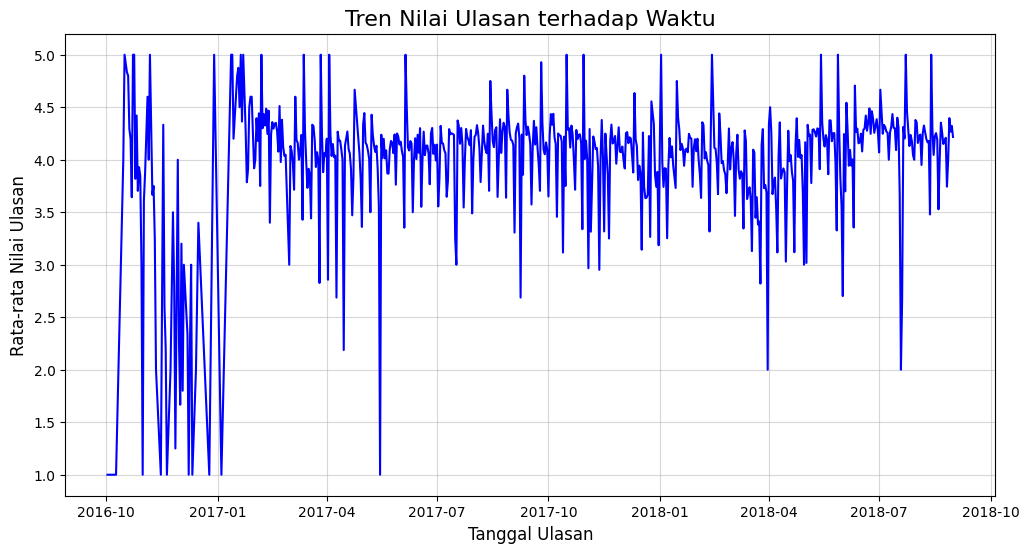

In [ ]:
# Konversi kolom tanggal menjadi format datetime
data['review_creation_date'] = pd.to_datetime(data['review_creation_date'])

# Kelompokkan data berdasarkan tanggal dan rata-rata nilai ulasan
avg_score_by_date = data.groupby('review_creation_date')['review_score'].mean().reset_index()

# Membuat line plot dengan Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_score_by_date, x='review_creation_date', y='review_score', color='blue')

# Menambahkan label dan judul
plt.title('Tren Nilai Ulasan terhadap Waktu', fontsize=16)
plt.xlabel('Tanggal Ulasan', fontsize=12)
plt.ylabel('Rata-rata Nilai Ulasan', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Multi-Bar Chart

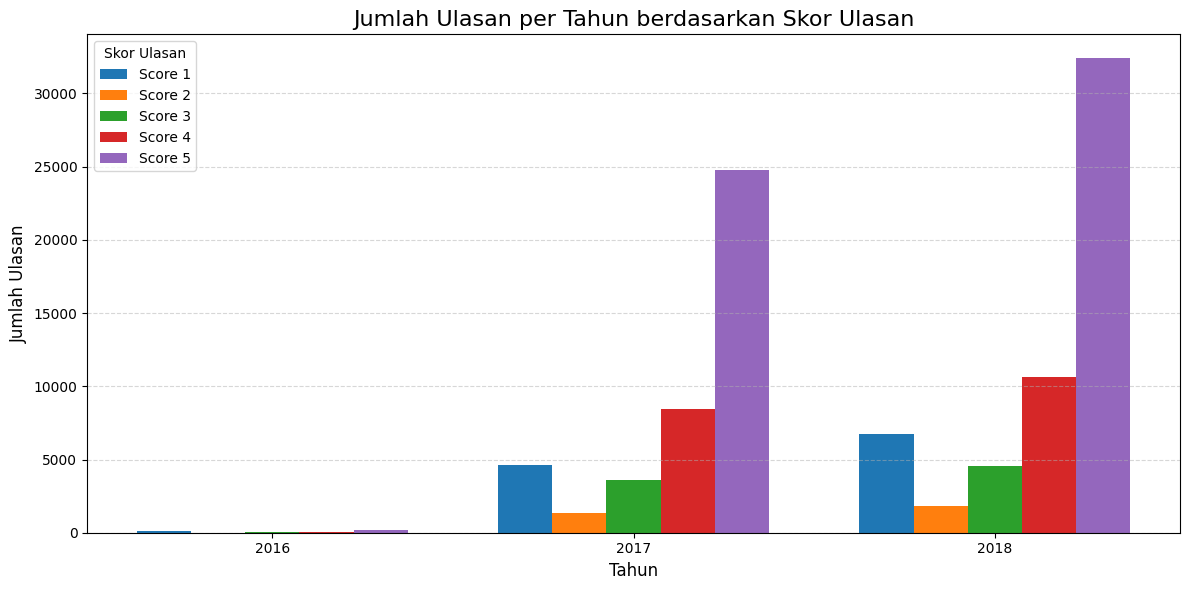

In [ ]:
# Tambahkan kolom tahun
data['year'] = data['review_creation_date'].dt.year

# Kelompokkan data berdasarkan tahun dan skor ulasan
grouped_data = data.groupby(['year', 'review_score']).size().unstack(fill_value=0)

# Membuat multi-bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.15  # Lebar setiap batang
x = range(len(grouped_data.index))  # Posisi untuk setiap tahun

# Plot setiap skor ulasan
for i, score in enumerate(grouped_data.columns):
    ax.bar([p + i * width for p in x], grouped_data[score], width=width, label=f'Score {score}')

# Menambahkan label dan elemen visual
ax.set_title('Jumlah Ulasan per Tahun berdasarkan Skor Ulasan', fontsize=16)
ax.set_xlabel('Tahun', fontsize=12)
ax.set_ylabel('Jumlah Ulasan', fontsize=12)
ax.set_xticks([p + (width * len(grouped_data.columns) / 2) - width / 2 for p in x])
ax.set_xticklabels(grouped_data.index)
ax.legend(title='Skor Ulasan')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tampilkan grafik
plt.tight_layout()
plt.show()

# Dashboard

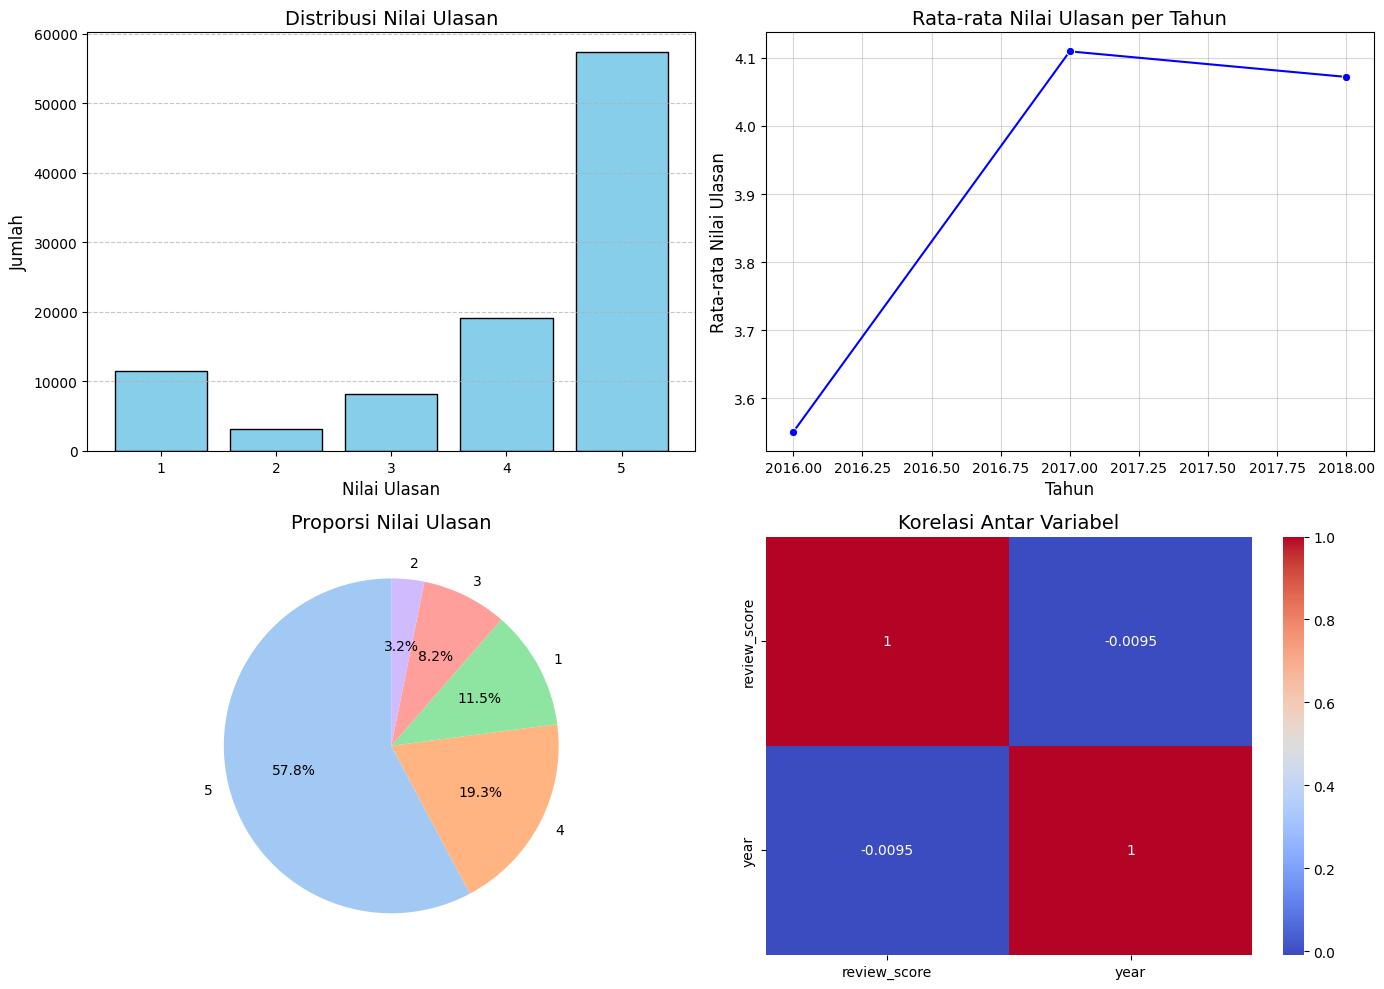

In [ ]:
# ---- DATA UNTUK VISUALISASI ----
# 1. Distribusi nilai ulasan
score_counts = data['review_score'].value_counts()

# 2. Rata-rata skor ulasan per tahun
avg_score_per_year = data.groupby('year')['review_score'].mean().reset_index()

# 3. Proporsi ulasan
score_proportion = score_counts / score_counts.sum()

# ---- MEMBUAT DASHBOARD ----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Bar chart: Distribusi nilai ulasan
axes[0, 0].bar(score_counts.index, score_counts, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribusi Nilai Ulasan', fontsize=14)
axes[0, 0].set_xlabel('Nilai Ulasan', fontsize=12)
axes[0, 0].set_ylabel('Jumlah', fontsize=12)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Line chart: Rata-rata nilai ulasan per tahun
sns.lineplot(data=avg_score_per_year, x='year', y='review_score', marker='o', ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Rata-rata Nilai Ulasan per Tahun', fontsize=14)
axes[0, 1].set_xlabel('Tahun', fontsize=12)
axes[0, 1].set_ylabel('Rata-rata Nilai Ulasan', fontsize=12)
axes[0, 1].grid(alpha=0.5)

# 3. Pie chart: Proporsi nilai ulasan
axes[1, 0].pie(score_proportion, labels=score_proportion.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
axes[1, 0].set_title('Proporsi Nilai Ulasan', fontsize=14)

# 4. Heatmap: Korelasi antar variabel (jika ada)
correlation = data[['review_score', 'year']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Korelasi Antar Variabel', fontsize=14)

# Tampilkan seluruh dashboard
plt.tight_layout()
plt.show()

# Inisialisasi Spark Session dan Memuat Dataset

In [ ]:
# Langkah 1: Inisialisasi Spark Session
spark = SparkSession.builder.appName("BinarySentimentClassification").getOrCreate()

# Langkah 2: Memuat Dataset
data_path = "cleaned_review.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Preprocessing

In [ ]:
# Menambahkan kolom label berdasarkan review_score
df = df.withColumn("label", when(col("review_score") >= 4, 1).otherwise(0))

# Mengonversi message_word_count menjadi tipe integer
df = df.withColumn("message_word_count", col("message_word_count").cast("int"))

# Menghapus baris dengan nilai null di kolom tertentu
df = df.na.drop(subset=["message_word_count", 'label'])

# Tampilkan beberapa data setelah preprocessing
df.show(5)

+--------------------+--------------------+------------+----------------------+--------------------+-----------------------+------------------+-----+
|           review_id|            order_id|review_score|review_comment_message|review_creation_date|review_answer_timestamp|message_word_count|label|
+--------------------+--------------------+------------+----------------------+--------------------+-----------------------+------------------+-----+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                  NULL| 2018-01-18 00:00:00|    2018-01-18 21:46:59|                 0|    1|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                  NULL| 2018-03-10 00:00:00|    2018-03-11 03:05:13|                 0|    1|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                  NULL| 2018-02-17 00:00:00|    2018-02-18 14:36:24|                 0|    1|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|  Recebi bem antes ...| 2017-04-21 00:00:00|

# Fitur Tambahan

In [ ]:
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import IntegerType

# Daftar kata negatif
negative_words = ['bad', 'poor', 'terrible', 'disappointing', 'worse', 'worst',
                  'unacceptable', 'not good', 'fail', 'problem', 'misleading',
                  'damaged', 'broken', 'defective', 'disgusting', 'hate']

# Buat UDF untuk menghitung jumlah kata negatif
def count_negative_keywords(review):
    if not isinstance(review, str):
        review = str(review)
    review = review.lower()
    return sum(review.count(word) for word in negative_words)

# Daftarkan UDF ke Spark
count_negative_udf = udf(count_negative_keywords, IntegerType())

# Tangani nilai null di review_comment_message
df = df.withColumn("review_comment_message", when(col("review_comment_message").isNull(), "Unknown").otherwise(col("review_comment_message")))

# Tambahkan kolom negative_word_count
df = df.withColumn("negative_word_count", count_negative_udf(col("review_comment_message")))

# Tampilkan beberapa data setelah menambahkan fitur
df.select("review_comment_message", "negative_word_count").show(5)

+----------------------+-------------------+
|review_comment_message|negative_word_count|
+----------------------+-------------------+
|               Unknown|                  0|
|               Unknown|                  0|
|               Unknown|                  0|
|  Recebi bem antes ...|                  0|
|  Parabéns lojas la...|                  0|
+----------------------+-------------------+
only showing top 5 rows



# Rekayasa Fitur - Membuat Vektor Fitur

In [ ]:
# Menambahkan kolom "features" yang menggabungkan message_word_count dan negative_word_count
assembler = VectorAssembler(inputCols=["message_word_count", "negative_word_count"], outputCol="features")
assembled_data = assembler.transform(df)

# Model Klasifikasi

In [ ]:
# Membuat dan melatih model RandomForest
classifier = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

# Membuat Pipeline

In [ ]:
pipeline = Pipeline(stages=[assembler, classifier])

# Training & Testing

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
print("Data Latih (Train Data) dan Data Uji (Test Data) Terpisah:")
print(f"Jumlah Data Latih: {train_data.count()}")
print(f"Jumlah Data Uji: {test_data.count()}")

Data Latih (Train Data) dan Data Uji (Test Data) Terpisah:
Jumlah Data Latih: 76246
Jumlah Data Uji: 19079


# Melatih Model

In [ ]:
model = pipeline.fit(train_data)

# Membuat Prediksi

In [ ]:
predictions = model.transform(test_data)
print("Prediksi Sampel:")
predictions.select("review_score", "message_word_count", "label", "prediction", "probability").show(10)

Prediksi Sampel:
+------------+------------------+-----+----------+--------------------+
|review_score|message_word_count|label|prediction|         probability|
+------------+------------------+-----+----------+--------------------+
|           5|                14|    1|       1.0|[0.43591397277679...|
|           5|                 2|    1|       1.0|[0.15145024905346...|
|           4|                 0|    1|       1.0|[0.15145024905346...|
|           3|                10|    0|       1.0|[0.25681291924887...|
|           4|                 0|    1|       1.0|[0.15145024905346...|
|           5|                 0|    1|       1.0|[0.15145024905346...|
|           5|                 0|    1|       1.0|[0.15145024905346...|
|           5|                 8|    1|       1.0|[0.21585093314358...|
|           5|                 0|    1|       1.0|[0.15145024905346...|
|           4|                 1|    1|       1.0|[0.15145024905346...|
+------------+------------------+-----+--------

# Evaluasi Model dengan Accuracy

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy Model: {accuracy:.2f}")

Accuracy Model: 0.80


# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Konversi prediksi dan label menjadi format untuk classification report
predicted_labels = predictions.select("label", "prediction").toPandas()
print("\nClassification Report:")
print(classification_report(predicted_labels['label'], predicted_labels['prediction']))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.26      0.37      4284
           1       0.82      0.96      0.88     14795

    accuracy                           0.80     19079
   macro avg       0.74      0.61      0.63     19079
weighted avg       0.78      0.80      0.77     19079



# Jumlah Ulasan

In [ ]:
sentiment_counts = predictions.groupBy("prediction").count().withColumnRenamed("count", "review_count")
sentiment_counts = sentiment_counts.withColumn("sentiment", when(col("prediction") == 1, "Positive").otherwise("Negative"))

sentiment_counts.select("sentiment", "review_count").show()

+---------+------------+
|sentiment|review_count|
+---------+------------+
| Negative|        1685|
| Positive|       17394|
+---------+------------+



# Visualisasi Sentimen

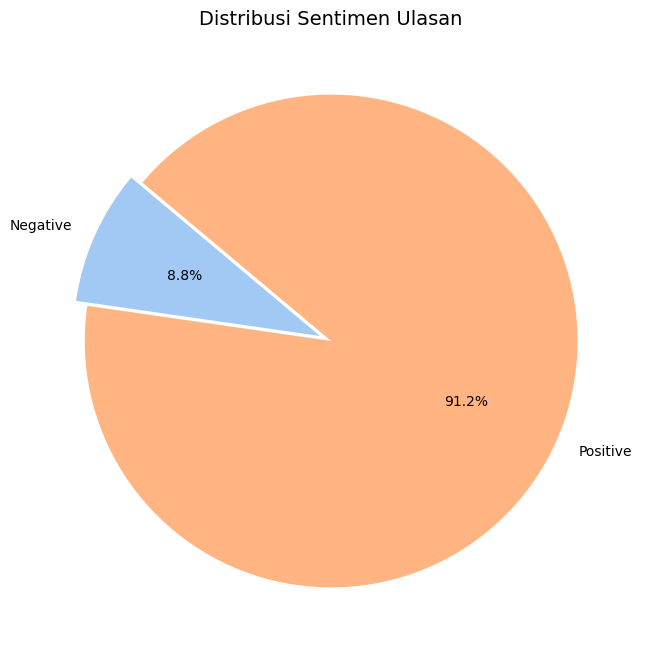

In [ ]:
# Mengonversi sentiment_counts Spark DataFrame ke Pandas
sentiment_counts_pd = sentiment_counts.select("sentiment", "review_count").toPandas()

# Membuat Pie Chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:2]
plt.pie(
    sentiment_counts_pd['review_count'],
    labels=sentiment_counts_pd['sentiment'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0.05, 0]
)
plt.title('Distribusi Sentimen Ulasan', fontsize=14)
plt.show()

# Confusion Matrix

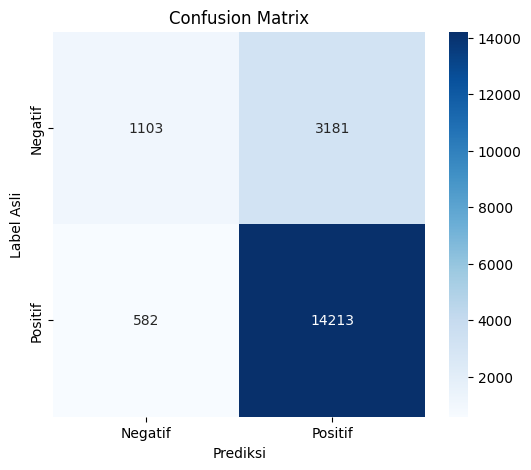

In [ ]:
from sklearn.metrics import confusion_matrix

predicted_labels = predictions.select("label", "prediction").toPandas()

cm = confusion_matrix(predicted_labels['label'], predicted_labels['prediction'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Label Asli')
plt.show()

# Hyperparameter Tuning

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Langkah 1: Inisialisasi Model Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Langkah 2: Membuat Pipeline (Vector Assembler + Random Forest)
assembler = VectorAssembler(inputCols=["message_word_count"], outputCol="features")
pipeline = Pipeline(stages=[assembler, rf])

# Langkah 3: Evaluator untuk Mengukur Kinerja Model
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Langkah 4: Definisi Parameter Grid untuk Random Forest
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# Langkah 5: CrossValidator untuk Hyperparameter Tuning
crossval = CrossValidator(
    estimator=pipeline,  # Pipeline yang dibuat sebelumnya
    estimatorParamMaps=paramGrid,  # Grid parameter
    evaluator=evaluator,  # Evaluator untuk kinerja model
    numFolds=3  # 3-Fold Cross-Validation
)

# Langkah 6: Melatih Model dengan Cross-Validation
cv_model = crossval.fit(train_data)

# Langkah 7: Mendapatkan Model dan Parameter Terbaik
best_rf_model = cv_model.bestModel.stages[-1]  # Model Random Forest terbaik dari pipeline
print("\nParameter Terbaik untuk Random Forest:")
print(f"Jumlah Pohon (numTrees): {best_rf_model.getNumTrees}")
print(f"Kedalaman Maksimum (maxDepth): {best_rf_model.getMaxDepth()}")
print(f"Jumlah Maksimum Bin (maxBins): {best_rf_model.getMaxBins()}")

# Langkah 8: Menggunakan Model Terbaik untuk Prediksi
best_predictions = cv_model.transform(test_data)

# Menampilkan Prediksi pada Data Uji
print("\nPrediksi Data Uji:")
best_predictions.select("label", "prediction", "probability").show(10)


Parameter Terbaik untuk Random Forest:
Jumlah Pohon (numTrees): 50
Kedalaman Maksimum (maxDepth): 10
Jumlah Maksimum Bin (maxBins): 64

Prediksi Data Uji:
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.43095642858920...|
|    1|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
|    0|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
|    1|       1.0|[0.16562840489909...|
+-----+----------+--------------------+
only showing top 10 rows

